In [1]:
import numpy as np
import torch
import torch.optim as optim
from matplotlib import pyplot as plt
import wandb

In [2]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from ppflows.uniform import ConditionalBox
from ppflows.permuters import EnergyOrderedPermutation

In [3]:
def sample(n, dim, prob, p_over):
    n_fill = 0
    x_out = np.zeros((n, dim))
    while n_fill < n:
        x = np.random.rand(n, dim)
        probs = prob(x)
        assert np.max(probs) < p_over

        x = x[p_over*np.random.rand(n) < probs]
        # Trim off extras
        if n_fill + x.shape[0] > n:
            # Excess is n_fill + x.shape[0] - n
            x = x[:n-n_fill]

        x_out[n_fill:n_fill+x.shape[0]] = x
        n_fill += x.shape[0]

    return x_out

In [4]:
def prob(x):
    #return 2*np.cos((x[:,0] + x[:,1])*np.pi)**2
    #return 4*np.exp(-x[:,0]**2 - x[:,1]**2)/np.pi/0.842700793/0.842700793	
    return 8*np.exp(-x[:,0]**2 -x[:,1]**2 -x[:,2]**2)/(np.pi**(3./2.))/0.842700793/0.842700793/0.842700793

In [5]:
def prob_ordered(x):
    probs = 6*prob(x)
    probs[x[:,0] < x[:,1]] = 0
    probs[x[:,0] < x[:,2]] = 0
    probs[x[:,1] < x[:,2]] = 0
    return probs

In [6]:
hyperparameters_default = {
    "n_RQS_knots": 10,              # Number of knots in RQS transform
    "n_made_layers": 3,             # Number of hidden layers in every made network
    "n_made_units": 25,             # Number of units in every layer of the made network
    "n_flow_layers": 6,             # Number of layers in the flow
    "batch_size": 512,
    "n_iterations": 5000,
    "learning_rate": 0.00025,
    "n_validate": 1000000
}
wandb.init(project="permutation", config=hyperparameters_default)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rbvh (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dist = ConditionalBox(3, device)

flow_transforms = []
for _ in range(config.n_flow_layers):
    flow_transforms.append(RandomPermutation(features=3))
    flow_transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=3, 
        hidden_features=config.n_made_units,
        num_bins=config.n_RQS_knots,
        num_blocks=config.n_made_layers,
        #tails="constrained",
        use_residual_blocks=False
    ))
composite_flow_transform = CompositeTransform(flow_transforms)
flow = Flow(composite_flow_transform, base_dist)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wandb.watch(flow, log="all")
optimizer = optim.Adam(flow.parameters(), lr=config.learning_rate)

In [9]:
permute_classes_1 = np.array([[0],[1],[2]])
permuter = EnergyOrderedPermutation(permute_classes_1, None)

In [10]:
for iteration in range(config.n_iterations):
    x_train = torch.tensor(sample(config.batch_size, 3, prob, 2.5), dtype=torch.float32)
    x_train = -torch.sort(-x_train)[0]
    x_train, _, log_prob_permute = permuter.forward(x_train, None)

    optimizer.zero_grad()
    loss = -( flow.log_prob(x_train) + log_prob_permute).mean()
    loss.backward()
    optimizer.step()

    if iteration%25 == 0:
        print("iteration = ", iteration, "loss = ", loss.item())

iteration =  0 loss =  2.618067502975464
iteration =  25 loss =  2.4388108253479004
iteration =  50 loss =  2.1169350147247314
iteration =  75 loss =  1.9101992845535278
iteration =  100 loss =  1.7610487937927246
iteration =  125 loss =  1.6462160348892212
iteration =  150 loss =  1.3305832147598267
iteration =  175 loss =  1.2536530494689941
iteration =  200 loss =  1.08221435546875
iteration =  225 loss =  1.0047416687011719
iteration =  250 loss =  0.9903789758682251
iteration =  275 loss =  0.844010591506958
iteration =  300 loss =  0.7329789996147156
iteration =  325 loss =  0.7719007730484009
iteration =  350 loss =  0.7581179141998291
iteration =  375 loss =  0.718468427658081
iteration =  400 loss =  0.8253235220909119
iteration =  425 loss =  0.7317319512367249
iteration =  450 loss =  0.786601722240448
iteration =  475 loss =  0.6771870255470276
iteration =  500 loss =  0.6152324080467224
iteration =  525 loss =  0.639844536781311
iteration =  550 loss =  0.4868965744972229


In [11]:
# Validation
with torch.no_grad():
    x_sample_flow = flow.sample(config.n_validate)
    log_prob = flow.log_prob(x_sample_flow)
    x_sample_flow, _, log_prob_permute = permuter.forward(x_sample_flow, None)
    
    print("log prob", (log_prob + log_prob_permute).mean().item())

log prob 0.06571882963180542


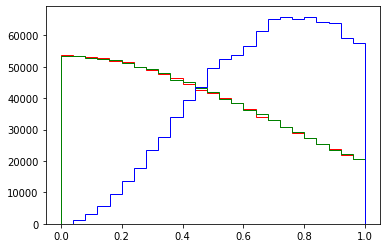

In [12]:
n = 1000000
x = np.random.rand(n,3)

colors = ['red', 'green', 'blue', 'orange']
plt.hist(x[:,0], weights=prob(x), bins=25, histtype='step', color=colors[0])
plt.hist(sample(n, 3, prob, 2.5)[:,0], bins=25, histtype='step', color=colors[1])
plt.hist(x_sample_flow.numpy()[:,0], bins=25, histtype='step', color=colors[2])
plt.show()

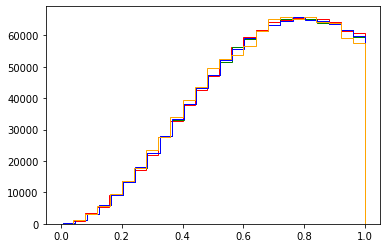

In [13]:
colors = ['red', 'green', 'blue', 'orange']
plt.hist(x[:,0], weights=prob_ordered(x), bins=25, histtype='step', color=colors[0])
plt.hist(sample(n, 3, prob_ordered, 15)[:,0], bins=25, histtype='step', color=colors[1])
plt.hist(-np.sort(-sample(n, 3, prob, 2.5))[:,0], bins=25, histtype='step', color=colors[2])
plt.hist(x_sample_flow.numpy()[:,0], bins=25, histtype='step', color=colors[3])
plt.show()

In [14]:
print((prob(x)*np.log(prob(x))).mean(), np.log(prob(sample(n, 3, prob, 2.5))).mean())

0.11443533714745374 0.11483176605864413


In [15]:
log_prob_ordered_1 = prob_ordered(x)
log_prob_ordered_1[log_prob_ordered_1 == 0.] = 1
log_prob_ordered_1 = np.log(log_prob_ordered_1)

In [16]:
print((prob_ordered(x)*log_prob_ordered_1).mean(), np.log(prob_ordered(sample(n, 3, prob_ordered, 15))).mean())

1.9094499469078727 1.906011304410595


In [17]:
1.9078422441336527 - 0.11468211698696339 - np.log(6)

0.0014006579186343071